## Setup

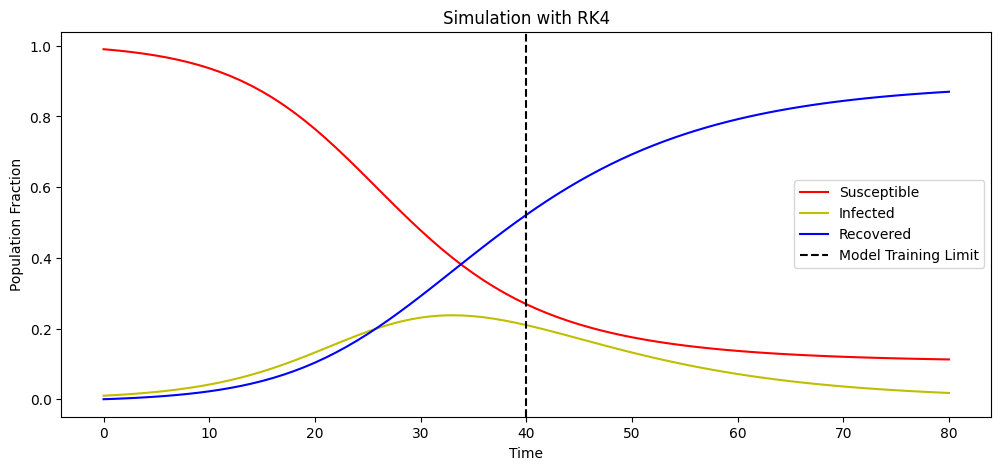

t_numpy_sir.shape: (81,)
u_numpy_sir.shape: (81, 3)
t_model_sir.shape: (41,)
u_model_sir.shape: (41, 3)


In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pysindy as ps
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

def ERK4(f, T_data, n, start_sir):

    h = T_data / n
    x0, y0, z0 = start_sir
    t_values = np.linspace(0, T_data, n+1)
    u_values = np.zeros((n+1, 3))
    u_values[0] = [x0, y0, z0]

    for i in range(n):
        t, x, y, z = t_values[i], *u_values[i]
        k1 = h * f(t, x, y, z)
        k2 = h * f(t + h / 2, x + k1[0] / 2, y + k1[1] / 2, z + k1[2] / 2)
        k3 = h * f(t + h / 2, x + k2[0] / 2, y + k2[1] / 2, z + k2[2] / 2)
        k4 = h * f(t + h, x + k3[0], y + k3[1], z + k3[2])
        u_values[i+1] = u_values[i] + (k1 + 2*k2 + 2*k3 + k4) / 6

    return t_values, u_values

def draw(f, T_data, T_model, n, start_sir):
    plt.figure(figsize=(12, 5))
    t, u = ERK4(f, T_data, n, start_sir)
    x, y, z = u.T

    plt.plot(t, x, label='Susceptible', c='r')
    plt.plot(t, y, label='Infected', c='y')
    plt.plot(t, z, label='Recovered', c='b')
    plt.axvline(T_model, linestyle='--', color='k', label='Model Training Limit')

    plt.title('Simulation with RK4')
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')
    plt.legend()
    plt.show()

beta = 0.25
gamma = 0.1
start_sir = [0.99, 0.01, 0.00]
T_data = 80
T_model = 40
n = 80

def SIR(t, S, I, R):
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

t_numpy_sir, u_numpy_sir = ERK4(SIR, T_data, n, start_sir)
draw(SIR, T_data, T_model, n, start_sir)

noise_level = 0.005
u_numpy_sir += np.random.normal(0, noise_level, u_numpy_sir.shape)

t_model_sir = t_numpy_sir[t_numpy_sir <= T_model]
u_model_sir = u_numpy_sir[t_numpy_sir <= T_model]

print(f't_numpy_sir.shape: {t_numpy_sir.shape}')
print(f'u_numpy_sir.shape: {u_numpy_sir.shape}')
print(f't_model_sir.shape: {t_model_sir.shape}')
print(f'u_model_sir.shape: {u_model_sir.shape}')

## Data

In [ ]:
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=["date"])
df = df[df["location"] == "United States"]

In [ ]:
# Use one wave
start_date, end_date = "2021-12-01", "2022-03-01"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

N = 331_000_000  # US population

# Estimate compartments
infectious_period = 14

#df["new_cases_smoothed"] = df["new_cases"].rolling(7, min_periods=1).mean()
df["I"] = df["new_cases_smoothed"].rolling(infectious_period, min_periods=1).sum()

df["R"] = df["total_cases"].shift(infectious_period).fillna(0)
df["R"] = df["R"].rolling(7, min_periods=1).mean()  # smooth recovery
df["S"] = N - df["I"] - df["R"]

# Normalize
df["S_norm"] = df["S"] / N
df["I_norm"] = df["I"] / N
df["R_norm"] = df["R"] / N

# Time in days
df["t"] = (df["date"] - df["date"].min()).dt.days
t = df["t"].values
S_obs = df["S_norm"].values
I_obs = df["I_norm"].values
R_obs = df["R_norm"].values

dates = df["date"]

# Plot
plt.figure(figsize=(10, 4))

plt.plot(dates, S_obs, "o", markersize=5, label="Actual Susceptible", color="blue")
plt.plot(dates, I_obs, "o", markersize=5, label="Actual Infected", color="red")
plt.plot(dates, R_obs, "o", markersize=5, label="Actual Recovered", color="green")

plt.title(f"US Covid-19 Data")
plt.xlabel("Date")
plt.ylabel("Normalized Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
t_numpy_covid = np.array(df["t"].values)  # shape [x, 1]
u_numpy_covid = np.array(df[["S_norm", "I_norm", "R_norm"]].values)  # shape [x, 3]

t_model_covid = t_numpy_covid[:t_numpy_covid.shape[0] // 2]  # shape [y, 1]
u_model_covid = u_numpy_covid[:t_numpy_covid.shape[0] // 2]  # shape [y, 3]

# Check
print("t_numpy_covid.shape:", t_numpy_covid.shape)
print("u_numpy_covid.shape:", u_numpy_covid.shape)
print("t_model_covid.shape:", t_model_covid.shape)
print("u_model_covid.shape:", u_model_covid.shape)

## Sindy


In [191]:
def sindy(lbd, t_train, u_train, start, t_numpy, u_numpy, title, T_model=T_model):
    sindy = ps.SINDy(
        feature_library=ps.PolynomialLibrary(degree=2),
        optimizer=ps.STLSQ(threshold=lbd)
    )
    sindy.fit(u_train, t=t_train)
    sindy.print()

    t_forecast = np.linspace(0, T_data, 100 * len(t_train))
    u_forecast = sindy.simulate(start, t_forecast)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t_numpy, u_numpy[:, 0], label='Susceptible (RK4)', c='midnightblue', lw=2.5)
    plt.plot(t_numpy, u_numpy[:, 1], label='Infected (RK4)', c='firebrick', lw=2.5)
    plt.plot(t_numpy, u_numpy[:, 2], label='Recovered (RK4)', c='yellowgreen', lw=2.5)

    t_forecast = t_forecast[:len(u_forecast)]
    plt.plot(t_forecast, u_forecast[:, 0], '--', label='Susceptible (SINDy)', c='blueviolet', lw=2.5, alpha=0.7)
    plt.plot(t_forecast, u_forecast[:, 1], '--', label='Infected (SINDy)', c='orangered', lw=2.5, alpha=0.7)
    plt.plot(t_forecast, u_forecast[:, 2], '--', label='Recovered (SINDy)', c='gold', lw=2.5, alpha=0.7)
    plt.axvline(T_model, linestyle='--', color='k', label='Model Training Limit')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')
    plt.legend()
    plt.show()

    # Interpolation
    interp_func = interp1d(t_numpy, u_numpy, axis=0, kind='cubic', fill_value="extrapolate")

    mask_train = t_forecast <= T_model
    mask_test = t_forecast > T_model
    mask_10 = (t_forecast > T_model) & (t_forecast <= T_model + 10)

    u_true_train = interp_func(t_forecast[mask_train])
    u_true_test = interp_func(t_forecast[mask_test])
    u_true_10 = interp_func(t_forecast[mask_10])

    train_loss = mean_squared_error(u_true_train, u_forecast[mask_train])
    test_loss = mean_squared_error(u_true_test, u_forecast[mask_test])
    mse_10 = mean_squared_error(u_true_10, u_forecast[mask_10])

    return train_loss, test_loss, mse_10


(x0)' = -1.520 1 + 3.106 x0 + 2.707 x1 + 2.755 x2 + -1.584 x0^2 + -3.016 x0 x1 + -2.964 x0 x2 + -3.558 x1 x2 + -0.865 x2^2
(x1)' = 0.062 x0 + 0.311 x1 + -0.350 x2 + -0.058 x0^2 + -0.406 x0 x1 + 0.473 x0 x2 + -0.582 x1 x2 + 0.434 x2^2
(x2)' = 0.073 1 + -0.068 x1 + -0.069 x0^2 + -0.137 x0 x1 + 0.021 x0 x2 + 0.135 x1^2 + -0.144 x2^2


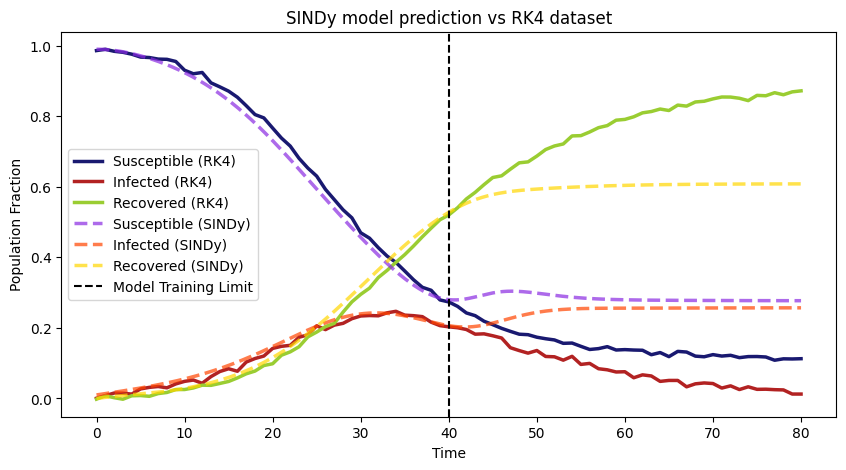

(0.000286946666886388, 0.027646232581796895, 0.004846330964613333)

In [192]:
title = 'SINDy model prediction vs RK4 dataset'
sindy(0.005, t_model_sir, u_model_sir, start_sir, t_numpy_sir, u_numpy_sir, title)

In [ ]:
title = 'SINDy model prediction vs Covid19 dataset'
sindy(0.004, t_model_covid, u_model_covid, u_numpy_covid[0], t_numpy_covid, u_numpy_covid, title, T_model=45)